<a href="https://colab.research.google.com/github/BrayanSmith31/My-Projects/blob/main/Challenge_MO_Thecnologies_Brayan_Pineda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
#Importing libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

!pip install tabulate  # With this we could format a dataframe in a tabular manner, and print two tables in the same cell code
from tabulate import tabulate

**1- Generate a script to create the database with the tables indicated in the ER model of the image.**


In [109]:
# Uploading the files(I have the files in the content folder in google colab)
customer_data = pd.read_csv('/content/customer.csv')
loan_data = pd.read_csv('/content/loan.csv')
payment_data = pd.read_csv('/content/payment.csv')

#Look at the tables
customer_data.head()
loan_data.head()
payment_data.head()

,id,loan_id,amount,status,paid_at
0,314e6efb-f6c3-4523-9b80-27f3f39d486a,96b81174-07df-4a64-a0a5-deb70b87e8cb,2.0,1,2023/06/27
1,60a88b1d-de9c-4127-ad78-cbb11fb2388b,8224f9e2-c8bd-4481-8a0d-df691d36b0fa,2.0,1,2023/06/27
2,58650204-5487-4475-9962-7b16cc18489d,f6b5ded9-9f9b-452f-8a60-d3c8ce6ee7f3,2.0,1,2023/06/27
3,b7902394-3b31-45bb-97b5-89966f97c75a,e52d89e9-61e0-4649-9e48-de387a783334,2.0,1,2023/06/27
4,b68a5800-f86b-4553-b41d-11706b5de9a6,4fae8759-ddb6-45ad-9810-26ea03b6557d,2.0,1,2023/06/27


In [110]:
#Changing the status of the loan and payment tables

status_loan = {
    1: 'active',
    2: 'paid',
    3: 'canceled',
    4: 'frozen'
}

status_payment = {
    1: 'accepted',
    2: 'reversed'
}

loan_data['status'] = loan_data['status'].map(status_loan)
payment_data['status'] = payment_data['status'].map(status_payment)

#Converting dates to datetime format
loan_data['disbursed_at'] = pd.to_datetime(loan_data['disbursed_at'])
payment_data['paid_at'] = pd.to_datetime(payment_data['paid_at'])



In [111]:
#Connect to SQLite
connection = sqlite3.connect('loan_management.db')
cursor = connection.cursor()

#Creating the customer table
cursor.execute('''
                CREATE TABLE IF NOT EXISTS Customer(
                  id TEXT PRIMARY KEY,
                  status TEXT
                  )
''')

#Creating the loan table
cursor.execute('''
                CREATE TABLE IF NOT EXISTS Loan(
                  id TEXT PRIMARY KEY,
                  customer_id TEXT,
                  amount INTEGER,
                  status TEXT,
                  disbursed_at DATE,
                  FOREIGN KEY (customer_id) REFERENCES Customer(id)
                )
''')

#Creating the payment table
cursor.execute('''
                CREATE TABLE IF NOT EXISTS Payment(
                  id TEXT PRIMARY KEY,
                  loan_id TEXT,
                  amount INTEGER,
                  status TEXT,
                  paid_at DATE,
                  FOREIGN KEY (loan_id) REFERENCES Loan(id)
                )
''')
connection.commit()
connection.close()


In [112]:
#Inserting the data into the tables
connection = sqlite3.connect('loan_management.db')
customer_data.to_sql('Customer', connection, if_exists = 'replace', index = False)
payment_data.to_sql('Payment', connection, if_exists = 'replace', index = False)
loan_data.to_sql('Loan', connection, if_exists = 'replace', index = False)



823

In [113]:
#Closing database connection
connection.close()

**Number of active loans granted per month**

In [133]:
#Connection to the database
connection = sqlite3.connect('loan_management.db')

#Query to get the number of active loans granted per month
active_loans_per_month_query = '''
    SELECT strftime('%Y-%m', disbursed_at) as month,
           COUNT(*) as active_loans
    FROM Loan
    WHERE status = 'active'
    GROUP BY month
'''

active_loans_per_month = pd.read_sql_query(active_loans_per_month_query, connection)

#Close connection
connection.close()

#Results
active_loans_per_month

,month,active_loans
0,2023-07,6


No charts were generated by quickchart


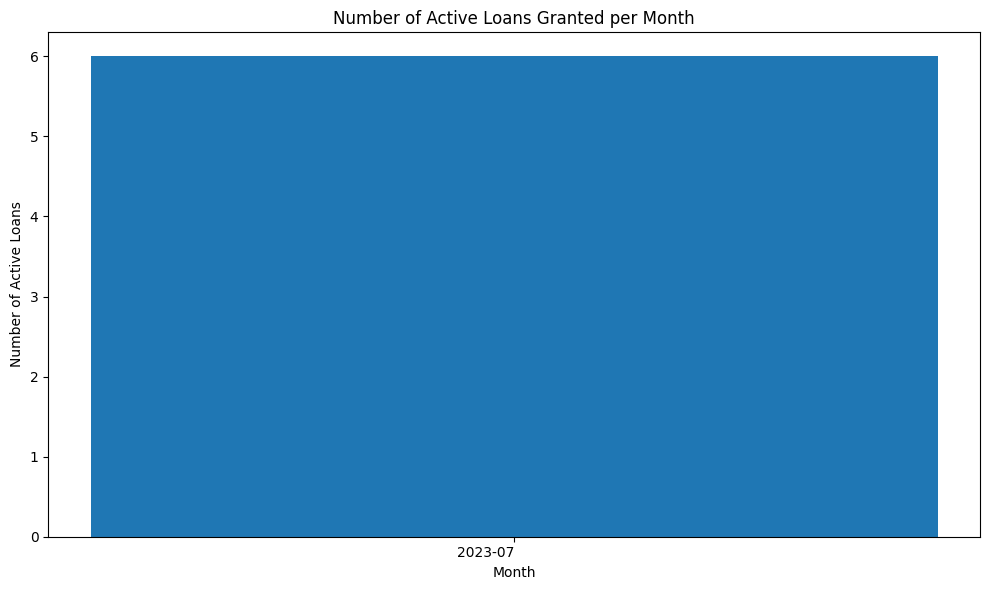

In [137]:
#Visualizations
plt.figure(figsize=(10, 6))
plt.bar(active_loans_per_month['month'], active_loans_per_month['active_loans'])
plt.xlabel('Month')
plt.ylabel('Number of Active Loans')
plt.title('Number of Active Loans Granted per Month')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()


**Number of loans and total amount lent per state**

In [138]:
# Connection to the database
connection = sqlite3.connect('loan_management.db')

# Query to get the number of loans and total amount lent per state
loans_per_state_query = '''
    SELECT status,
           COUNT(*) as num_loans,
           SUM(amount) as total_amount
    FROM Loan
    GROUP BY status
'''
loans_per_state = pd.read_sql_query(loans_per_state_query, connection)

# Close the connection
connection.close()

# Results
loans_per_state

,status,num_loans,total_amount
0,active,6,5619.0
1,canceled,410,180686.0
2,frozen,9,53.0
3,paid,398,25735.0


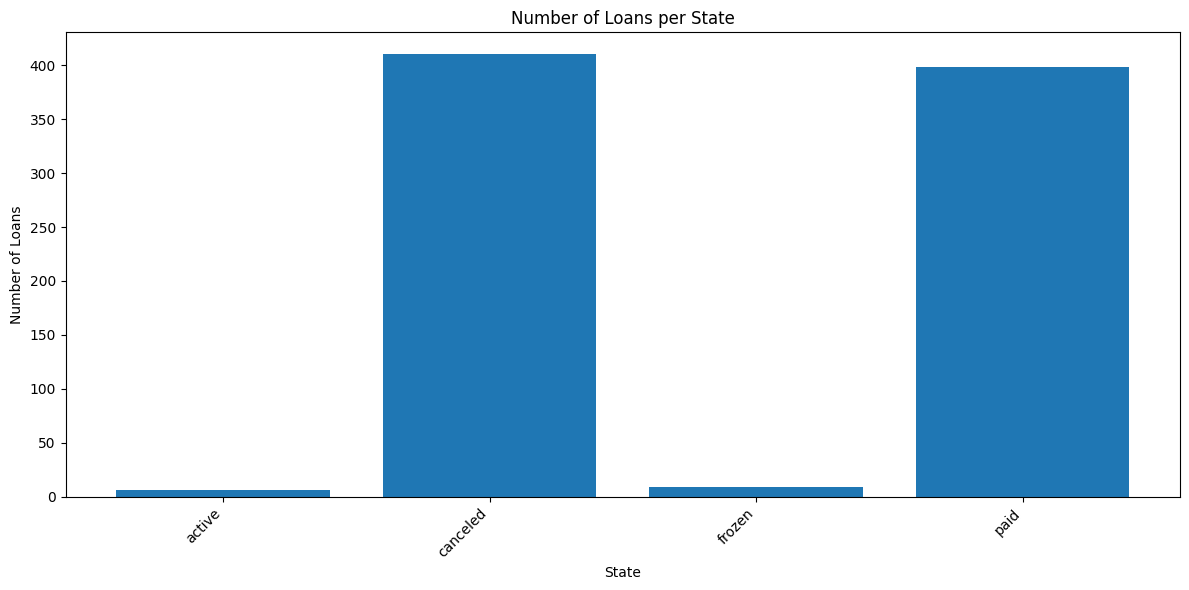

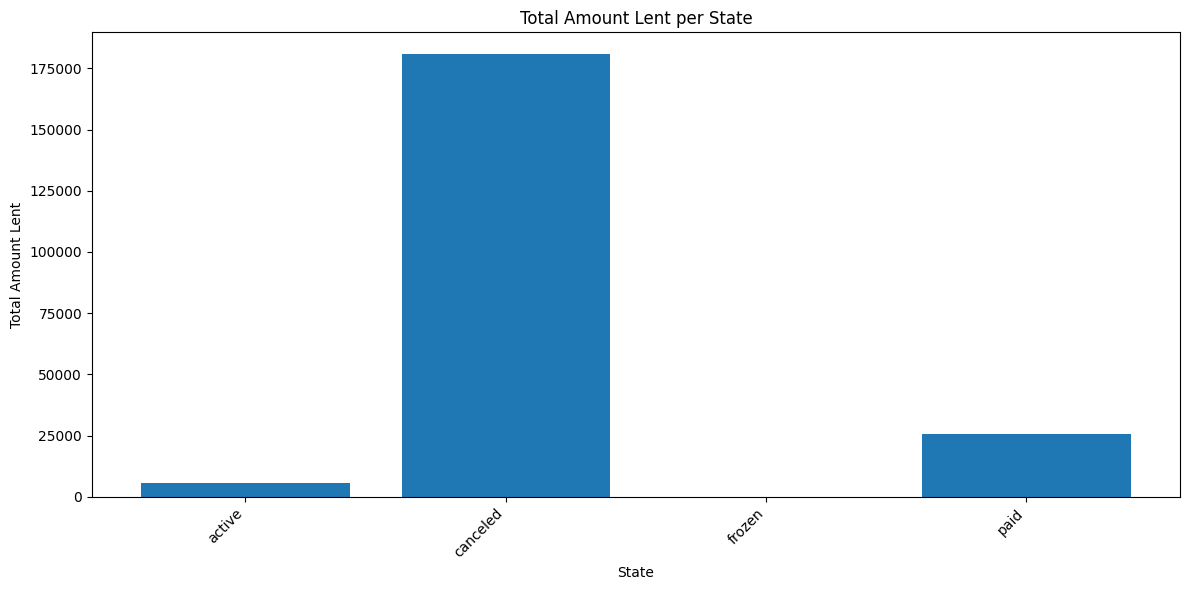

In [141]:
#Visualizations
## Number of loans per state
plt.figure(figsize=(12, 6))
plt.bar(loans_per_state['status'], loans_per_state['num_loans'])
plt.xlabel('State')
plt.ylabel('Number of Loans')
plt.title('Number of Loans per State')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Total amount lent per state
plt.figure(figsize=(12, 6))
plt.bar(loans_per_state['status'], loans_per_state['total_amount'])
plt.xlabel('State')
plt.ylabel('Total Amount Lent')
plt.title('Total Amount Lent per State')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

**Number of payments and total amount paid by each client**

In [119]:
# Connection to the database
connection = sqlite3.connect('loan_management.db')

# Query to get the number of payments and total amount paid by each client
payments_per_client_query = '''
    SELECT l.customer_id,
           c.status as client_status,
           COUNT(*) as num_payments,
           SUM(p.amount) as total_paid_amount
    FROM Payment p
    INNER JOIN Loan l ON p.loan_id = l.id
    INNER JOIN Customer c ON l.customer_id = c.id
    GROUP BY l.customer_id
'''
payments_per_client = pd.read_sql_query(payments_per_client_query, connection)

# Close the connection
connection.close()

# Results
payments_per_client

,customer_id,client_status,num_payments,total_paid_amount
0,012f680e-b7a5-459c-bcc4-aaa304f8d1f3,enabled,4,12.0
1,01fddeb9-0759-4293-800c-43eb17477253,enabled,2,4.0
2,026d1e55-7b4c-450c-ae16-1500eb2f63b8,enabled,16,1370.0
3,02ed1155-3f59-49c8-b57a-cd4d8fa14dc6,enabled,2,804.0
4,0317e384-e8ed-40a3-8e6c-f3f136c6e983,enabled,1,1.0
...,...,...,...,...
358,fccc4185-7df3-4b77-a336-6e6d65769899,enabled,2,150.0
359,fd14bd1c-8f4c-4ab3-96dc-6e39de80eb62,enabled,1,3.0
360,fd43612e-7b31-4b21-8bb1-f213e48f2ad8,enabled,3,6.0
361,fdd20433-7dc4-4841-b57e-36fd5aa5d272,enabled,1,2.0


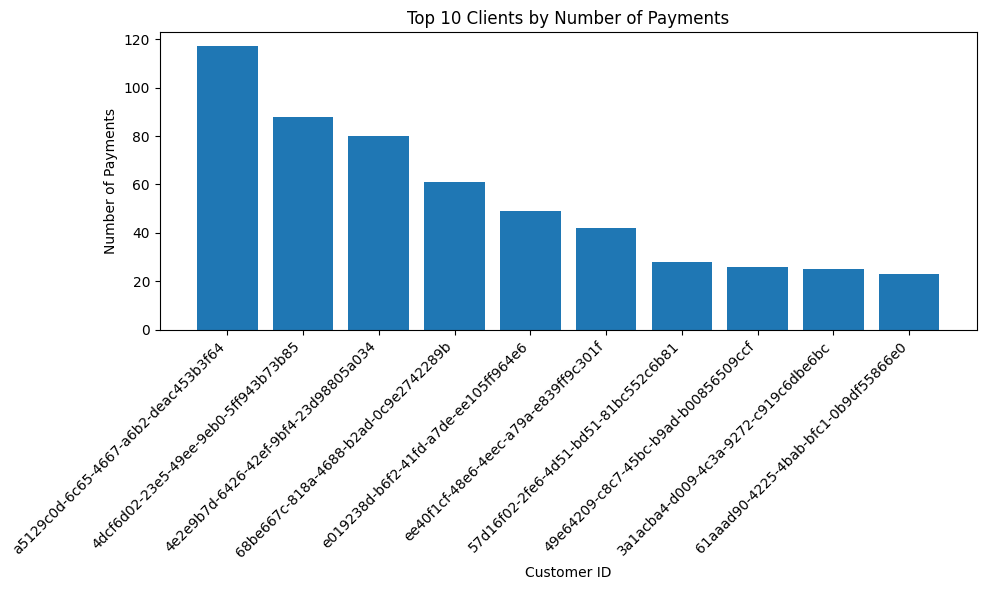

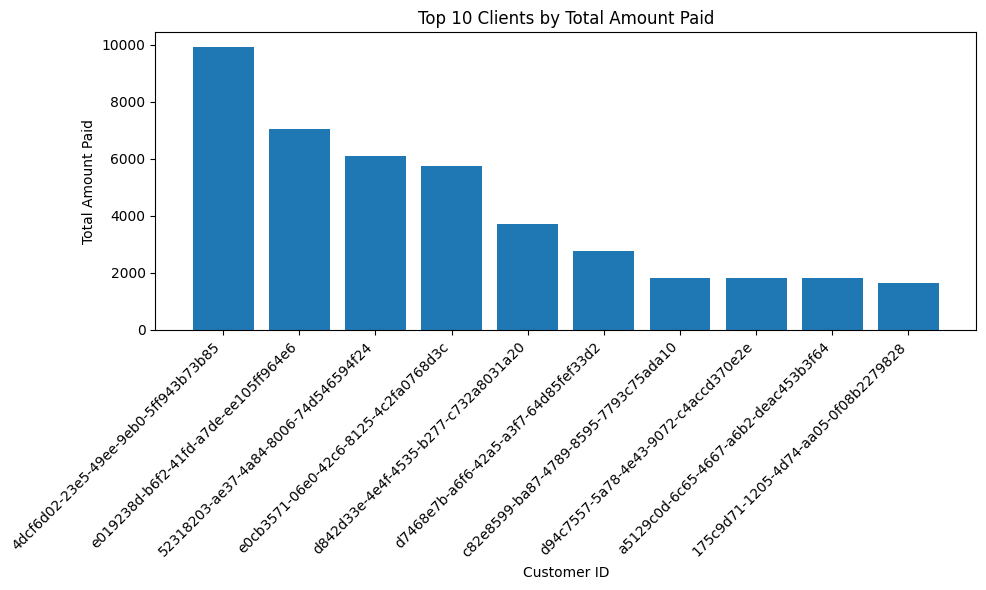

In [147]:
#Visualizations
# TOP 10: Number of payments per client
top_10_clients_by_num_payments = payments_per_client.nlargest(10, 'num_payments')
plt.figure(figsize=(10, 6))
plt.bar(top_10_clients_by_num_payments['customer_id'], top_10_clients_by_num_payments['num_payments'])
plt.xlabel('Customer ID')
plt.ylabel('Number of Payments')
plt.title('Top 10 Clients by Number of Payments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# TOP 10: Number of payments per client
top_10_clients_by_total_amount_paid = payments_per_client.nlargest(10, 'total_paid_amount')
plt.figure(figsize=(10, 6))
plt.bar(top_10_clients_by_total_amount_paid['customer_id'], top_10_clients_by_total_amount_paid['total_paid_amount'])
plt.xlabel('Customer ID')
plt.ylabel('Total Amount Paid')
plt.title('Top 10 Clients by Total Amount Paid')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

**For each client indicate which is the oldest and most recent loan**


In [150]:
# Connection to the database
connection = sqlite3.connect('loan_management.db')

# Oldest loan per client
oldest_loan_per_client_query = '''
    SELECT customer_id, MIN(disbursed_at) as oldest_loan_date
    FROM Loan
    GROUP BY customer_id
'''
oldest_loan_per_client = pd.read_sql_query(oldest_loan_per_client_query, connection)

# Most recent loan per client
most_recent_loan_per_client_query = '''
    SELECT customer_id, MAX(disbursed_at) as most_recent_loan_date
    FROM Loan
    GROUP BY customer_id
'''
most_recent_loan_per_client = pd.read_sql_query(most_recent_loan_per_client_query, connection)

# Close the connection
connection.close()

# Merging the two DataFrames to get the final result
oldest_and_most_recent_loans = pd.merge(oldest_loan_per_client, most_recent_loan_per_client, on='customer_id')

# Result
oldest_and_most_recent_loans

,customer_id,oldest_loan_date,most_recent_loan_date
0,012f680e-b7a5-459c-bcc4-aaa304f8d1f3,2023-01-05 00:00:00,2023-01-05 00:00:00
1,01fddeb9-0759-4293-800c-43eb17477253,2023-06-21 00:00:00,2023-06-21 00:00:00
2,026d1e55-7b4c-450c-ae16-1500eb2f63b8,2022-11-03 00:00:00,2022-12-21 00:00:00
3,02ed1155-3f59-49c8-b57a-cd4d8fa14dc6,2023-01-30 00:00:00,2023-01-30 00:00:00
4,0317e384-e8ed-40a3-8e6c-f3f136c6e983,2023-06-27 00:00:00,2023-06-27 00:00:00
...,...,...,...
363,fccc4185-7df3-4b77-a336-6e6d65769899,2023-06-15 00:00:00,2023-06-15 00:00:00
364,fd14bd1c-8f4c-4ab3-96dc-6e39de80eb62,2023-06-22 00:00:00,2023-06-22 00:00:00
365,fd43612e-7b31-4b21-8bb1-f213e48f2ad8,2023-04-17 00:00:00,2023-04-17 00:00:00
366,fdd20433-7dc4-4841-b57e-36fd5aa5d272,2023-06-30 00:00:00,2023-06-30 00:00:00


In [163]:
#Visualizations
## TOP 5 Clients with oldest loans
top_10_oldest_loans = oldest_and_most_recent_loans.sort_values(by='oldest_loan_date').head(5)
print(tabulate(top_10_oldest_loans.reset_index(), headers = 'keys', tablefmt = 'fancy_grid'))

## TOP 5 Clients with most recent loans
top_10_most_recent_loans = oldest_and_most_recent_loans.sort_values(by='most_recent_loan_date', ascending=False).head(5)
print(tabulate(top_10_most_recent_loans.reset_index(), headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤═════════╤══════════════════════════════════════╤═════════════════════╤═════════════════════════╕
│    │   index │ customer_id                          │ oldest_loan_date    │ most_recent_loan_date   │
╞════╪═════════╪══════════════════════════════════════╪═════════════════════╪═════════════════════════╡
│  0 │     346 │ f4f16e66-43ff-4ca8-865b-fa221e6f1b28 │ 2022-09-10 00:00:00 │ 2022-09-10 00:00:00     │
├────┼─────────┼──────────────────────────────────────┼─────────────────────┼─────────────────────────┤
│  1 │     314 │ e0cb3571-06e0-42c6-8125-4c2fa0768d3c │ 2022-10-14 00:00:00 │ 2022-10-14 00:00:00     │
├────┼─────────┼──────────────────────────────────────┼─────────────────────┼─────────────────────────┤
│  2 │     299 │ d842d33e-4e4f-4535-b277-c732a8031a20 │ 2022-10-18 00:00:00 │ 2022-10-18 00:00:00     │
├────┼─────────┼──────────────────────────────────────┼─────────────────────┼─────────────────────────┤
│  3 │     298 │ d7468e7b-a6f6-42a5-a3f7-64d85fef33d2 │ 2022-10-

**Clients whose total paid value is greater than 500**

In [166]:
# Connection to the database
connection = sqlite3.connect('loan_management.db')

# Query to get the clients whose total paid value is greater than 500
clients_paid_greater_than_500_query = '''
    SELECT l.customer_id,
           c.status as client_status,
           SUM(p.amount) as total_paid_amount
    FROM Payment p
    INNER JOIN Loan l ON p.loan_id = l.id
    INNER JOIN Customer c ON l.customer_id = c.id
    GROUP BY l.customer_id
    HAVING total_paid_amount > 500
'''
clients_paid_greater_than_500 = pd.read_sql_query(clients_paid_greater_than_500_query, connection)

# Close the connection
connection.close()

# Display the result
clients_paid_greater_than_500

,customer_id,client_status,total_paid_amount
0,026d1e55-7b4c-450c-ae16-1500eb2f63b8,enabled,1370.0
1,02ed1155-3f59-49c8-b57a-cd4d8fa14dc6,enabled,804.0
2,12d8dc24-90e6-466a-9d2e-703eb9f68968,enabled,1030.0
3,137d5863-b44a-48cb-9cce-d53378394996,enabled,519.0
4,175c9d71-1205-4d74-aa05-0f08b2279828,enabled,1650.0
5,2372af09-4e3b-4b15-993b-8a5cd8d47db0,enabled,519.0
6,2a3aebab-8474-4392-af1f-a5a2d5da8ec2,enabled,804.0
7,2fd9efe7-7536-4d38-8e40-a59593a6a100,enabled,744.0
8,3248d28f-d86d-453c-80c1-3152df6a090d,enabled,519.0
9,32efeaf2-e895-431e-bebc-eff05c36a743,enabled,1030.0


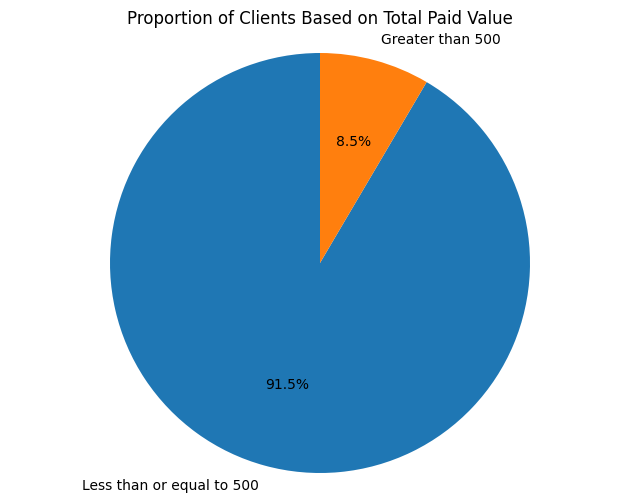

In [175]:
#Visualizations
# Proportion of clients whose total paid value is greater than 500
connection = sqlite3.connect('loan_management.db')

# Query to get the total amount paid by each client
total_paid_per_client_query = '''
    SELECT loan_id, SUM(amount) as total_paid_amount
    FROM Payment
    GROUP BY loan_id
'''

total_paid_per_client = pd.read_sql_query(total_paid_per_client_query, connection)

# Close the connection
connection.close()

# Two groups : Greater than 500 and Lower/equal 500
total_paid_per_client['paid_group'] = total_paid_per_client['total_paid_amount'].apply(lambda x: 'Greater than 500' if x > 500 else 'Less than or equal to 500')

# Proportion of clients in each group
paid_group_proportions = total_paid_per_client['paid_group'].value_counts(normalize=True)

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(paid_group_proportions, labels=paid_group_proportions.index, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Clients Based on Total Paid Value')
plt.axis('equal')
plt.show()




